In [1]:
#importing the necessary dependencies

import numpy as np
import sys
import scipy
from numpy import array
caffe_root = '/path/to/caffe/'
sys.path.insert(0, caffe_root + 'python')
import caffe
from caffe.proto import caffe_pb2
from skimage import transform
import matplotlib.pyplot as plt
import cv2
import os
import math

%matplotlib inline

In [18]:
#initializing the model

#Specifying to use the GPU
caffe.set_mode_gpu()
caffe.set_device(0)

net = caffe.Classifier('../models/bvlc_alexnet/deploy.prototxt','../models/bvlc_alexnet/bvlc_alexnet.caffemodel',channel_swap=(2,1,0))
#BGR mean values
mean = np.array([103.939, 116.779, 123.68])

#Dictionary assigning a layer number to different layers of alexNet
blob ={0:'conv1',1:'pool1',2:'conv2',3:'pool2',4:'conv3',5:'conv4',6:'conv5',7:'pool5',8:'fc6',9:'fc7',10:'fc8'}

In [33]:
#Member functions

def pool2conv(ind, layer_in, K, S):
#Backtrace locations from pool to conv layer
	for cr in range(5):
		layer_out = []
		if layer_in[cr]!=0:
			for i in layer_in[cr]:
				#Getting the receptive region the pool operates on
				x = (S*i[1], S*i[1] + K)
				y = (S*i[2], S*i[2] + K)
				#Getting most contributing x and y relative to the region being operated on
				x1, y1 = np.unravel_index(np.argmax(net.blobs[blob[ind-1]].data[cr,i[0],x[0]:x[1],y[0]:y[1]]), [K,K])
				layer_out.append((i[0],x[0]+x1,y[0]+y1))
		layer_in[cr] = list(set(layer_out))
        return layer_in

def conv2conv(ind, layer_in, K, S, P):
#Backtrace locations between conv layers
	for cr in range(5):
		layer_out = []
		if layer_in[cr]!=0:
			for i in layer_in[cr]:
				#Defining receptive field along both axes
				x = (S*i[1], S*i[1]+K)
				y = (S*i[2], S*i[2]+K)
				p_s = net.params[blob[ind]][0].data.shape[1]	
				b_s = net.blobs[blob[ind-1]].data.shape[1]
				flag = False	#Flag to check for grouping parameter	
				if p_s != b_s:
					if i[0]>=p_s/2: # Pick the right group.
						flag = True		
						#Getting and Padding blob data of previous layer	
						data = np.lib.pad(net.blobs[blob[ind-1]].data[cr,b_s/2:b_s,:,:], P , 'constant', constant_values = 0)[:, x[0]:x[1], y[0]:y[1]]
						#The weights of current layer corresponding to channel
						param = net.params[blob[ind]][0].data[i[0],:,:,:]
					else:
						#Getting and Padding blob data of previous layer
						data = np.lib.pad(net.blobs[blob[ind-1]].data[cr,:b_s/2,:,:], P , 'constant', constant_values = 0)[:, x[0]:x[1], y[0]:y[1]]
						#The weights of current layer corresponding to channel
						param = net.params[blob[ind]][0].data[i[0],:,:,:]
				else:
					#Getting and Padding blob data of previous layer
					data = np.lib.pad(net.blobs[blob[ind-1]].data[cr,:,:,:], P , 'constant', constant_values = 0)[:, x[0]:x[1], y[0]:y[1]]
					#The weights of current layer corresponding to channel
					param = net.params[blob[ind]][0].data[i[0],:,:,:]
				data=data[P:-P,:,:]
				CONV = data*param
				#Getting most contributing position
				feature=np.argmax(np.sum(np.sum(CONV,axis=2),axis=1))
				if flag:
					feature+=b_s/2
				layer_out.append((feature,x[0],y[0]))
			layer_in[cr]=list(set(layer_out))
        return layer_in

def fc2pool(ind, layer_in):
#Backtrace locations from fc to pool layer
	for cr in range(5):
		layer_out = []
		if layer_in[cr]!=0:
			for i in layer_in[cr]:
				#Flattening the blob values to perform in place multiplication
				data = np.reshape(net.blobs[blob[ind-1]].data[cr,:],[9216,])
            			param = net.params[blob[ind]][0].data[i,:]
            			CONV = data*param
				#Getting Top positions for each input
            			feature=np.argmax(CONV)
	                	feat, x, y = np.unravel_index(feature,net.blobs[blob[ind-1]].data.shape[1:])
                		layer_out.append((feat,x,y))
		layer_in[cr] = list(set(layer_out))
        return layer_in

def fc2fc(ind, layer_in):
#Backtrace between fc layers
    for cr in range(5):
        layer_out = []
        if layer_in[cr]!=0:
            #Blob values for prevous layer
            data = net.blobs[blob[ind-1]].data[cr,:]
            #Weights for the current layer
            param = net.params[blob[ind]][0].data
            CONV = data*param
            for i in layer_in[cr]:
                #Getting Top-num activations for each input
                num = np.sum(CONV[i,:]>0)
                feature=np.argsort(CONV[i,:])[::-1][:num]
                layer_out.extend(feature)
            layer_in[cr] = list(set(layer_out))
    return layer_in

def out_rem(pts, diag):
    values = pts
    neighbors = np.zeros((values.shape[0]))
    selPoints = np.empty((1,2))
    for i in range(values.shape[0]):
        diff = np.sqrt(np.sum(np.square(values-values[i]),axis=1))
        neighbors[i] = np.sum(diff<diag)
    for i in range(values.shape[0]):
        if neighbors[i]>0.05*values.shape[0]:
            selPoints = np.append(selPoints,values[i:i+1,:],axis=0)
    selPoints = selPoints[1:,:]
    selPoints = selPoints.astype(int)
    return selPoints

def heatmap(img, pts, sigma=20):
    k = (np.min(img.shape[:2])) if (np.min(img.shape[:2])%2==1) else (np.min(img.shape[:2])-1)
    mask = np.zeros(img.shape[:2])
    shape = mask.shape
    for i in range(pts.shape[0]):
        if pts[i,0]<shape[0] and pts[i,1]<shape[1]:
            mask[pts[i,0],pts[i,1]] += 1
    blur = cv2.GaussianBlur(mask,(k,k),sigma)
    blur = blur*255/np.max(blur)
    return blur

In [38]:
#loading ilsvrc synset
synsets = open('ilsvrc_synsets.txt').readlines()

#Put the path to test image here
img_path = 'sample.jpg'
img=caffe.io.load_image(img_path)

#Preprocessing the image
resFac = 256.0/min(img.shape[:2])
newSize = map(int,(img.shape[0]*resFac,img.shape[1]*resFac))
img = transform.resize(img, newSize)
net.image_dims = newSize
#The offsets for the crops
inc = [[0,0],[0,newSize[1]-224],[newSize[0]-227,0],[newSize[0]-227,newSize[1]-227],[newSize[0]/2.0-114,newSize[1]/2.0-114]]
img = img*255.0
img[:,:,0]-=mean[2]
img[:,:,1]-=mean[1]
img[:,:,2]-=mean[0]
#Passing image through network
net.predict([img],oversample=True)
p = net.blobs['prob'].data
#The mean label
p_mean = np.argmax(np.mean(p,axis=0))
image_label = synsets[p_mean].split(',')[0]
image_label = image_label[image_label.index(' ')+1:]
crop_labels = [np.argmax(p[0]),np.argmax(p[1]),np.argmax(p[2]),np.argmax(p[3]),np.argmax(p[4])]
#To check if mean label does not match any crop
if p_mean in crop_labels:
	p_m = p_mean
else:
    p_m = crop_labels[4]
crops = []
#To check which crops to consider
for i in range(5):
    if np.argmax(p[i,:])==p_m:
        crops.append(1)
    else:
        crops.append(0)
values = [[],[],[],[],[]]
for cr in range(5):
			if crops[cr]==1:
				values[cr].append(crop_labels[cr])
			else:
				values[cr]=0
#Calling the fuctions to backtract through the network
values = fc2fc(10,values)
values = fc2fc(9,values)
values = fc2pool(8,values)
values = pool2conv(7,values,3,2)
values = conv2conv(6,values,3,1,1)
values = conv2conv(5,values,3,1,1)
values = conv2conv(4,values,3,1,1)
values = pool2conv(3,values,3,2)
values = conv2conv(2,values,5,1,2)
values = pool2conv(1,values,3,2)

output = []
#To get the coordinates back to image size
for cr in range(5):
    if values[cr]!=-1:
        for i in values[cr]:
            output.append((int((i[1]*4+inc[cr][0])*(1/resFac)),int((i[2]*4+inc[cr][1])*(1/resFac))))

(<matplotlib.image.AxesImage at 0x7f24aebcbf90>,
 (-0.5, 499.5, 399.5, -0.5),
 <matplotlib.text.Text at 0x7f24aec12c90>)

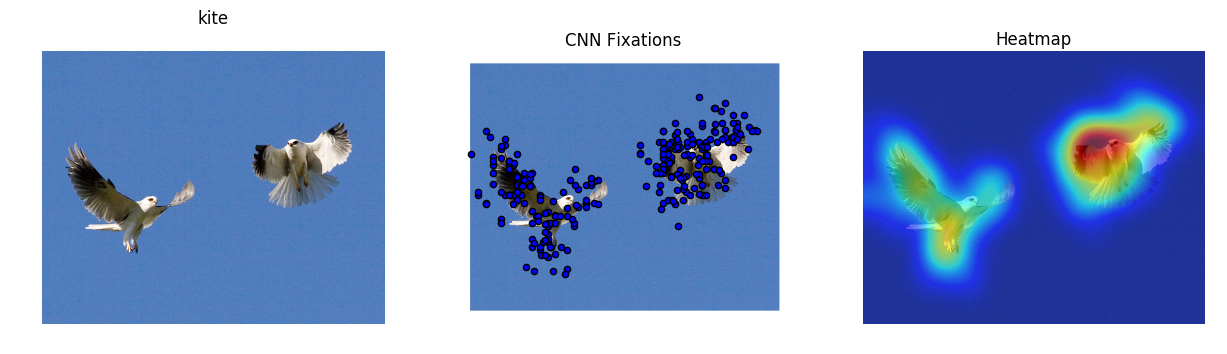

In [37]:
#Visualization
img = cv2.imread(img_path)
b,g,r = cv2.split(img)
img = cv2.merge((r,g,b))
diag = math.sqrt(img.shape[0]**2 + img.shape[1]**2)*0.1
values = np.asarray(output)
selPoints = out_rem(values, diag)
hm = heatmap(np.copy(img), selPoints)

_, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(img),ax[0].axis('off'),ax[0].set_title(image_label)
ax[1].imshow(img),ax[1].axis('off'),ax[1].scatter(selPoints[:,1],selPoints[:,0]),ax[1].set_title('CNN Fixations')
ax[2].imshow(img),ax[2].imshow(hm, alpha=0.6),ax[2].axis('off'),ax[2].set_title('Heatmap')